In [1]:
# FFD, Bspline, MS-GAN
path_BEM     = "/home/sh/WCY/auto_propeller/resource4/0_data/BsplineProp.ini"

path_FFDpara  = "/home/sh/WCY/auto_propeller/resource4/1_model/base_para_FFD.npy"
path_FFDpoint = "/home/sh/WCY/auto_propeller/resource4/1_model/base_point_FFD.npy"

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time
import os 
import numpy as np
import csv
import ast
import sys
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import pickle
import pandas as pd
import time
def fluent(data):
    new_x = np.linspace(0,1,200)
    x     = np.linspace(0,1,data.shape[0])
    f = interpolate.interp1d(x,data,'cubic')
    new_data = f(new_x)
    return new_data


def create_line(x,y,z,ax,chord,R):
    lenth = x.shape[0]
   
    z_mean = np.mean(z)
    y_mean = np.mean(y)
    x_mean = np.mean(x)

    center_z = z_mean - R*3/3
    center_y = y_mean
    center_x = x_mean
    center = np.array([[center_x,center_y,center_z]]).repeat(lenth,0)
    
    theta_left = np.arcsin(chord/R)
    theta_left = 0.002
    theta = np.linspace(-theta_left,theta_left,lenth)

    dis_x = np.zeros(x.shape[0])
    displace = np.array([dis_x,R*np.sin(theta),R*np.cos(theta)]).T

    line  = center +  displace
    
    line = line[::3,:]
    # ax.scatter3D(line[:,0],line[:,1],line[:,2],s = 1,c = 'cyan')

    return line


def draw_geom_line(foil_data,elev = -65,azim = 10):

    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    ax.set_xlim(0,1)
    ax.set_ylim(-0.5,0.5)
    ax.set_zlim(-0.5,0.5)

    ax.view_init(elev=elev, azim=azim)

    outline = []

    lines = []
    for i in range(foil_data.shape[0]):

        x = foil_data[i,:,0]
        y = foil_data[i,:,1]
        z = foil_data[i,:,2]

        y_left  = np.argmin(y)
        y_right = np.argmax(y)

        tmp     = [[x[y_left],y[y_left],z[y_left]],[x[y_right],y[y_right],z[y_right]]]
        p_range = outline.append(tmp)

        ax.scatter3D(x,y,z,s = 5,c = 'tomato',alpha = 0.5)
        line = create_line(x,y,z,ax,np.abs(y[y_right] - y[y_left]),100)
        lines.append(line)
        ax.plot3D(x,y,z, c = 'gray',alpha = 0.5)
        
    lines = np.array(lines)
    outline = np.array(outline)
    x_left = fluent(outline[:,0,0])
    y_left = fluent(outline[:,0,1])
    z_left = fluent(outline[:,0,2])
    
    x_right = fluent(outline[:,1,0])
    y_right = fluent(outline[:,1,1])
    z_right = fluent(outline[:,1,2])

    ax.plot3D(x_left,y_left,z_left, c = 'k',alpha = 0.5)
    ax.plot3D(x_right,y_right,z_right, c = 'k',alpha = 0.5)
    
    plt.axis('off')
    # plt.savefig(pic_name)
    plt.show()
    plt.close()
    return lines

(1224, 64) (64, 3)
(18, 68, 3)


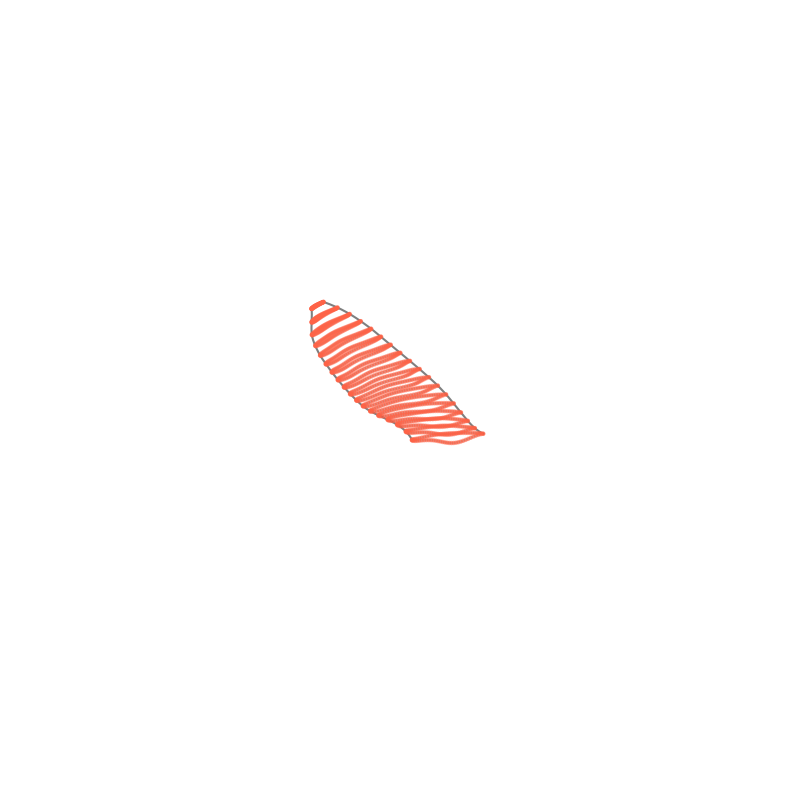

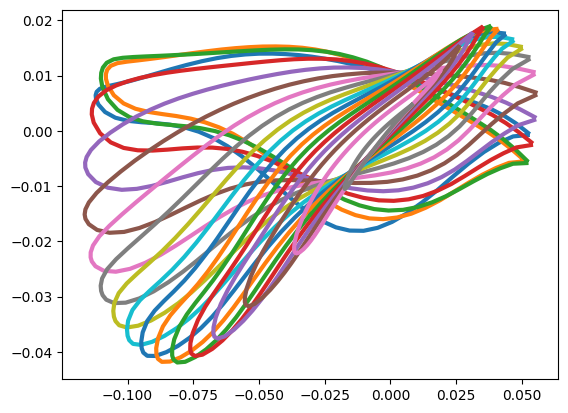

In [3]:
BasePara  = np.load(path_FFDpara)
BasePoint = np.load(path_FFDpoint)

print(BasePara.shape, BasePoint.shape)
BaseMesh  = np.dot(BasePara, BasePoint).reshape(18,68,3)
print(BaseMesh.shape)

lines = draw_geom_line(BaseMesh, -20, 20)

for i, data in enumerate(BaseMesh):
    
    plt.plot(data[:, 1], data[:, 2], linewidth=3)

plt.show()

In [4]:
import utils.ffd.deform as deform

def draw_ffd(foil_data,point = np.array([])):
    def draw_geom1(foil_data,ax,alpha=0.3):
    # p = foil_data
        x = foil_data[:,:,0]
        y = foil_data[:,:,1]
        z = foil_data[:,:,2]

        ax.plot_surface(x,y,z,color='#3d7afd',alpha = alpha)

        plt.axis('off')

        return ax
    def draw_mesh1(foil_data,ax,alpha=0.3):
    # p = foil_data
        x = foil_data[:,:,0]
        y = foil_data[:,:,1]
        z = foil_data[:,:,2]

        ax.scatter3D(x,y,z,color='b',alpha = alpha,s=0.05)

        plt.axis('off')

        return ax
    def draw_ffd1(foil_data,ax):
        # p = foil_data
        x = foil_data[:,0]
        y = foil_data[:,1]
        z = foil_data[:,2]

        ax.scatter3D(x,y,z,s=10,c = 'r', label = "FFD control points")

        
        # plt.show()
        # plt.close()

        return ax
    def draw_round(foil_data,ax):
        # p = foil_data
        x = foil_data[:,:,0].reshape(-1)
        y = foil_data[:,:,1].reshape(-1)
        z = foil_data[:,:,2].reshape(-1)

        ax.plot3D(x,y,z,alpha = 0.5,c='gray')

        # plt.axis('off')
        
        # plt.close()

        return ax
    def draw_line(foil_data,ax):
        # p = foil_data
        x = foil_data[:,0].reshape(-1)
        y = foil_data[:,1].reshape(-1)
        z = foil_data[:,2].reshape(-1)

        ax.plot3D(x,y,z,alpha = 0.5,c='gray')

        # plt.axis('off')
        
        # plt.close()

        return ax
    
    present_geom = foil_data
    dim = (3,7,1)
    _ = present_geom.reshape(-1,3)
    para,points = deform.get_ffd(_,dim)
    
    if point.shape[0] == 0:
        point = points

    fig = plt.figure(figsize=(18,12))
    ax = plt.axes(projection="3d")
    ax.set_xlim(0,1)
    ax.set_ylim(-0.5,0.5)
    ax.set_zlim(-0.5,0.5)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.zaxis.set_visible(False)
    plt.axis('off')
    ax = draw_geom1(present_geom,ax)
    ax = draw_mesh1(present_geom,ax)
    # ax = draw_ffd1(point,ax)
    new_plots = point.reshape(4,8,2,3)
    for i in range(new_plots.shape[0]):
        a = new_plots[i,:,:,:]
        a = a.transpose(1,0,2)
        a[0,:,:] = a[0,::-1,:]
        p1  = a[0,0,:]
        p2  = a[-1,-1,:]
        # ax = draw_round(a,ax)
        # ax.plot3D([p1[0],p2[0]],[p1[1],p2[1]],[p1[2],p2[2]],alpha = 0.5,c='gray')

    for j in range(new_plots.shape[1]):
        for k in range(new_plots.shape[2]):
            if j%2==0:
                b = new_plots[:,j,k,:]
                # ax = draw_line(b,ax)

    radius = 0.17
    thickness  = 0.05

    dim = (18, 68, 3)
    tmp = np.linspace(0,2*np.pi,30)
    ttmp = np.linspace(radius,0,50)

    for i,j in enumerate( ttmp):
        x = j * np.cos(tmp)[None,:]
        y = j * np.sin(tmp)[None,:]
        z0 = np.array([thickness for _ in range(30)])[None,:]
        z1 = np.array([-thickness for _ in range(30)])[None,:]
        create_geom = np.concatenate((x,y,z0),0).T[None,:]
        # b = np.concatenate((x,y,z1),0).T[None,:]
        # create_geom = np.concatenate((a,b),0)
        if i ==0:
            create_geoms = create_geom
        else:
            create_geoms = np.concatenate((create_geoms,create_geom),0)
    create_geoms0 = create_geoms.transpose(1,0,2)
    for i,j in enumerate( ttmp):
        x = j * np.cos(tmp)[None,:]
        y = j * np.sin(tmp)[None,:]
        z0 = np.array([thickness for _ in range(30)])[None,:]
        z1 = np.array([-thickness for _ in range(30)])[None,:]
        create_geom = np.concatenate((x,y,z1),0).T[None,:]
        # b = np.concatenate((x,y,z1),0).T[None,:]
        # create_geom = np.concatenate((a,b),0)
        if i ==0:
            create_geoms = create_geom
        else:
            create_geoms = np.concatenate((create_geoms,create_geom),0)
    create_geoms1 = create_geoms.transpose(1,0,2)

    x = radius * np.cos(tmp)[None,:]
    y = radius * np.sin(tmp)[None,:]
    z0 = np.array([thickness for _ in range(30)])[None,:]
    z1 = np.array([-thickness for _ in range(30)])[None,:]
    a = np.concatenate((x,y,z0),0).T[None,:]
    b = np.concatenate((x,y,z1),0).T[None,:]
    create_geoms2 = np.concatenate((a,b),0)

    # create_geoms = np.concatenate((create_geoms0,create_geoms1),1)
    ax = draw_geom1(create_geoms1,ax,alpha=0.8)
    ax = draw_geom1(create_geoms0,ax,alpha=0.8)

    ax = draw_geom1(create_geoms2,ax,alpha=0.8)

    reversed_geoms = -present_geom

    ax = draw_geom1(reversed_geoms,ax,alpha=0.8)
    # plt.savefig(path + '/' + name)
    ax.legend(loc='upper right')  # 改变图例的位置
    plt.savefig("FFD controlpoints.pdf")
    plt.show()
    
    plt.close()

    return point


********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


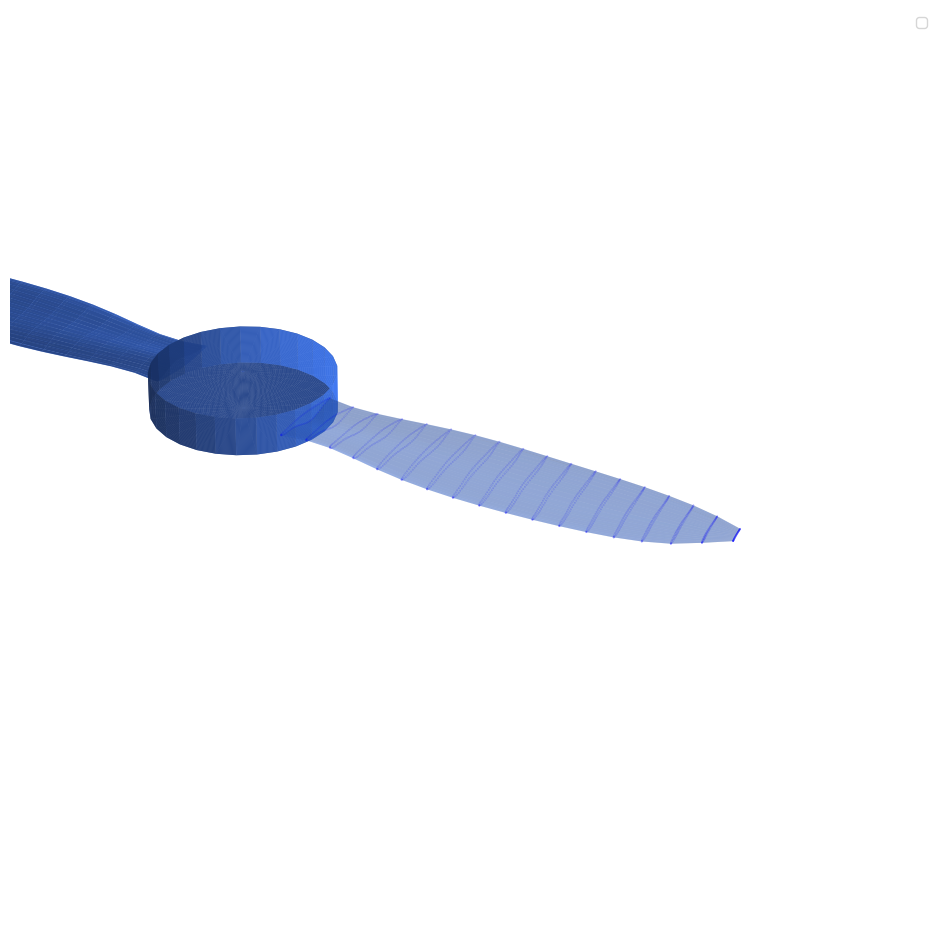

In [5]:
Point = draw_ffd(BaseMesh)

In [6]:
from utils import Geometry
start_mesh = np.load('/home/sh/WCY/auto_propeller/resource4/0_data/start_mesh.npy')
print(start_mesh.shape)

Radius_list, Chord_list, Pitch_list, SectionCoordinate_list = \
Geometry.build_BEMprop_from_PointsCloud(start_mesh)

chorddist, twistdist = Chord_list, Pitch_list


(18, 68, 3)


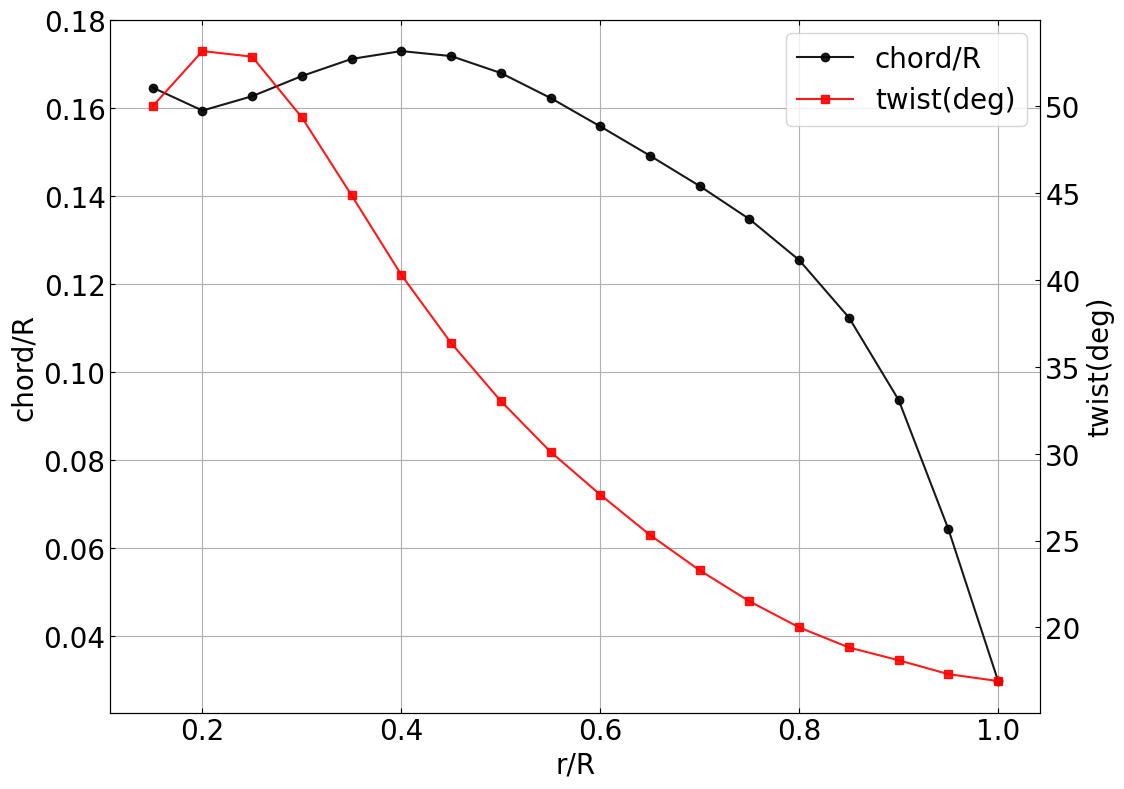

In [7]:
plt.rcParams['font.size'] = 20  # 可以调整这个值来设置字体大小

fig, axs = plt.subplots(1,1, figsize=(12,9))

line1 = axs.plot(Radius_list,chorddist,color="k",marker = "o", alpha = 0.9, label = "chord/R")
ax2 = axs.twinx()
line2 = ax2.plot(Radius_list,twistdist ,color="r", marker = "s",alpha=0.9, label= "twist(deg)" )
lines = line1 + line2 
axs.tick_params(axis='both',      # 应用于x轴和y轴
                    direction='in',
                which='both',        # 应用于主刻度线和次刻度线
                bottom=True,         # 隐藏底部刻度线
                top=True,            # 隐藏顶部刻度线
                left=True,           # 隐藏左侧刻度线
                right=False)         # 隐藏右侧刻度线

ax2.tick_params(axis='both',          # 应用于x轴和y轴
                    direction='in',
                which='both',         # 应用于主刻度线和次刻度线
                bottom=False,         # 隐藏底部刻度线
                top=False,            # 隐藏顶部刻度线
                left=False,           # 隐藏左侧刻度线
                right=True)          # 隐藏右侧刻度线

labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc = "upper right")
axs.set_ylabel("chord/R")
ax2.set_ylabel("twist(deg)")
axs.set_xlabel("r/R")
axs.grid(True)
plt.savefig("geom baseline.pdf")
plt.show()

/tmp/ipykernel_232237/1241948641.py:42: UserWarning: The label '_child2' of <matplotlib.collections.PathCollection object at 0x7ce3d3c9fd60> starts with '_'. It is thus excluded from the legend.
  axs.legend(lines, labels, loc = "upper right")
/tmp/ipykernel_232237/1241948641.py:42: UserWarning: The label '_child3' of <matplotlib.collections.PathCollection object at 0x7ce3d3caf4f0> starts with '_'. It is thus excluded from the legend.
  axs.legend(lines, labels, loc = "upper right")
/tmp/ipykernel_232237/1241948641.py:42: UserWarning: The label '_child4' of <matplotlib.collections.PathCollection object at 0x7ce3d3caf940> starts with '_'. It is thus excluded from the legend.
  axs.legend(lines, labels, loc = "upper right")
/tmp/ipykernel_232237/1241948641.py:42: UserWarning: The label '_child5' of <matplotlib.collections.PathCollection object at 0x7ce3d3cafd90> starts with '_'. It is thus excluded from the legend.
  axs.legend(lines, labels, loc = "upper right")
/tmp/ipykernel_232237/12

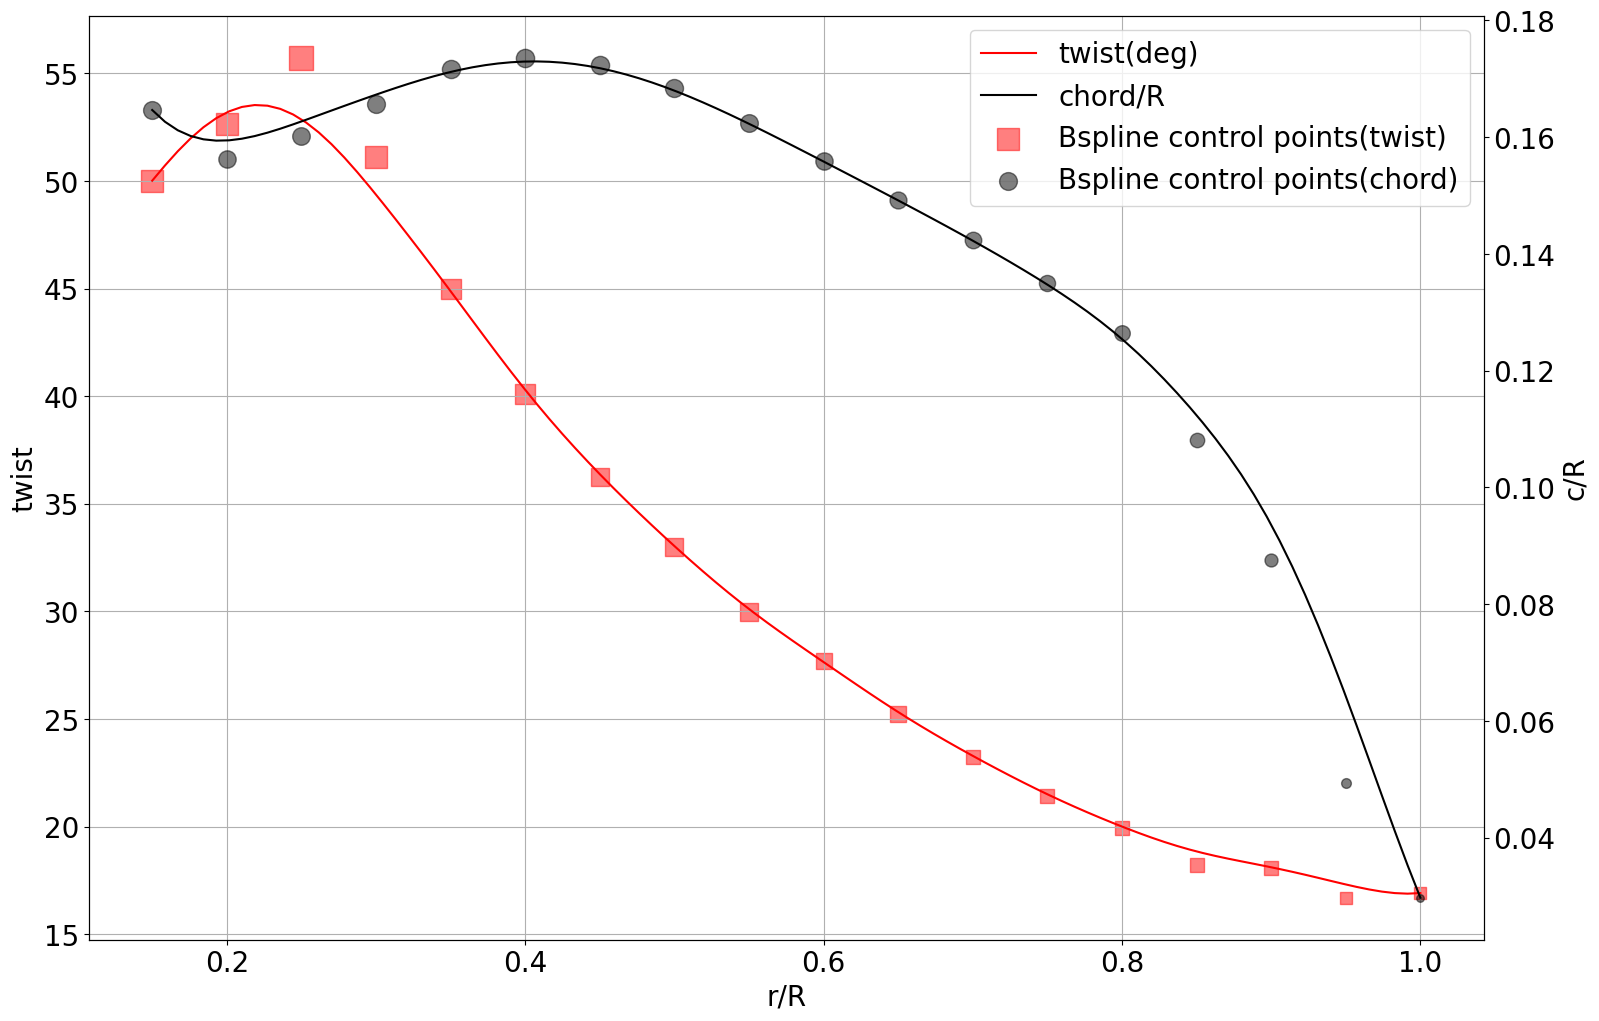

In [8]:
Bspline_x = np.load("/home/sh/WCY/auto_propeller/resource4/2_output/test_Bspline/Bspline_x.npy")
t_pitch, c_pitch, _ = interpolate.splrep(Radius_list, Pitch_list, s=0, k=4)

# 创建BSpline对象并计算曲线在一系列点上的值
x_new = np.linspace(Radius_list[0], Radius_list[-1] ,100)
y_new = interpolate.splev(x_new, (t_pitch, c_pitch, 4))

# 绘图
fig, axs =  plt.subplots(1,1, figsize=(18,12))

line2 = axs.plot(x_new, y_new ,color="r",alpha=1, label= "twist(deg)" )

# 绘制控制点
# 这里假定 radius 点本身作为 x 坐标的控制点位置
scatter_points = []
for i, coef in enumerate(c_pitch):
    if i < len(Radius_list):  # 仅绘制有效的控制点
        scatter = axs.scatter(Radius_list[i], coef, s=np.abs(coef)*5, marker='s', c = "r", alpha = 0.5 , label=f'Bspline control points(twist)' if i == 0 else "")
        scatter_points.append(scatter)

# plt.title('B-Spline with Control Points Indicating Weights')
axs.set_xlabel('r/R')
axs.set_ylabel('twist')

ax2 = axs.twinx()

t_chord, c_chord, _ = interpolate.splrep(Radius_list, Chord_list, s=0, k=4)

# 创建BSpline对象并计算曲线在一系列点上的值
x_new = np.linspace(Radius_list[0], Radius_list[-1] ,100)
y_new = interpolate.splev(x_new, (t_chord, c_chord, 4))
line1 = ax2.plot(x_new, y_new ,color="k",alpha=1, label=  "chord/R" )

for i, coef in enumerate(c_chord):
    if i < len(Radius_list):  # 仅绘制有效的控制点
        scatter = ax2.scatter(Radius_list[i], coef, s=np.abs(coef)*1000, marker='o', c = "k", alpha = 0.5 , label=f'Bspline control points(chord)' if i == 0 else "")
        # scatter = ax2.scatter(Radius_list[i], coef, s=np.abs(coef)*1000,edgecolors='', marker='o',facecolors='none', alpha = 0.5 , label=f'MS-GAN latent dim.' if i == 0 else "")
        scatter_points.append(scatter)

lines = line2 + line1 + scatter_points
labels = [l.get_label() for l in lines]
axs.legend(lines, labels, loc = "upper right")
ax2.set_ylabel("c/R")
# axs.grid(True)
axs.grid(True)
plt.savefig("Bspline controlpoints.pdf")

# plt.show()

In [9]:
#  result in 3，6，1

Bspline_x = '/home/sh/WCY/auto_propeller/resource4/2_output/test_Bspline/saved3/Bspline_x.npy'
FFD_x = '/home/sh/WCY/auto_propeller/resource4/2_output/test_Bspline/saved6/Bspline_x.npy'
MSGAN_x = '/home/sh/WCY/auto_propeller/resource4/2_output/test_Bspline/saved1/Bspline_x.npy'
MSGAN_process_FM = '/home/sh/WCY/auto_propeller/resource4/2_output/test_Bspline/saved1/Bspline_process_eta.npy'


FM = np.load(MSGAN_process_FM)
print(FM.shape)

def get_Bspline(radius,pitch,k=4):
    t_pitch,c_pitch,_  = interpolate.splrep(radius,pitch,s=0,k=k)
    
    tail     = np.zeros(k+1)
    c_pitch  = c_pitch[:len(radius)]
    return t_pitch,c_pitch,tail
def get_para(list):
    list = abs(list)
    try:
        lenth = len(list[0])
    except:
        lenth = 1 
    return np.max(list),lenth





(500,)


In [10]:
x = np.load(MSGAN_x)
from utils.BEMT_program import solver
geom_path = '/home/sh/WCY/auto_propeller/resource4/0_data/BsplineProp.ini'
s = solver.Solver(geom_path)
sections = s.rotor.sections
foil_name = []
radius   = []
pitch    = []
chord    = []

v_inf    = s.v_inf
rpm      = s.rpm
for i in sections:
    foil_name.append(i.airfoil.name)
    radius.append(i.radius)
    pitch.append(i.pitch)
    chord.append(i.chord)

num_sec = len(foil_name)
radius,pitch,c_R = np.array(radius),np.array(pitch),np.array(chord)

t_pitch,c_pitch,tail = get_Bspline(radius,pitch,k=4)
t_cR,c_cR,_ = get_Bspline(radius,c_R,k=4)
tail0       = np.expand_dims(tail,0).repeat(x.shape[0],axis=0)
t_pitch   = np.expand_dims(t_pitch,0).repeat(x.shape[0],axis=0)
c_pitch   = np.expand_dims(c_pitch,0).repeat(x.shape[0],axis=0)
t_cR     = np.expand_dims(t_cR,0).repeat(x.shape[0],axis=0)
c_cR     = np.expand_dims(c_cR,0).repeat(x.shape[0],axis=0)


para0,len0 = get_para(c_pitch)
para1,len1 = get_para(c_cR)

cur_p     = 0       
c_pitch   = np.add(x[:,cur_p:cur_p+len0]*para0,c_pitch)
c_pitch   = np.concatenate((c_pitch,tail0),1)
cur_p    += len0

c_cR      = np.add(x[:,cur_p:cur_p+len1]*para1,c_cR)
c_cR      = np.concatenate((c_cR,tail0),1)


In [11]:
x = np.load(MSGAN_x)

def reduce_B(radius,t,c,k=4):

    pitch_x = []
    for i in range(len(t)):
        t1 = t[i]
        c1 = c[i]

        pitch_x.append(interpolate.splev(radius,(t1,c1,k)))
    pitch_x = np.array(pitch_x)

    return pitch_x

from utils.BEMT_program import solver
geom_path = '/home/sh/WCY/auto_propeller/resource4/0_data/BsplineProp.ini'
s = solver.Solver(geom_path)
sections = s.rotor.sections
foil_name = []
radius   = []
pitch    = []
chord    = []

v_inf    = s.v_inf
rpm      = s.rpm
for i in sections:
    foil_name.append(i.airfoil.name)
    radius.append(i.radius)
    pitch.append(i.pitch)
    chord.append(i.chord)

num_sec = len(foil_name)
radius,pitch,c_R = np.array(radius),np.array(pitch),np.array(chord)

t_pitch,c_pitch,tail = get_Bspline(radius,pitch,k=4)
t_cR,c_cR,_ = get_Bspline(radius,c_R,k=4)
tail0       = np.expand_dims(tail,0).repeat(x.shape[0],axis=0)
t_pitch   = np.expand_dims(t_pitch,0).repeat(x.shape[0],axis=0)
c_pitch   = np.expand_dims(c_pitch,0).repeat(x.shape[0],axis=0)
t_cR     = np.expand_dims(t_cR,0).repeat(x.shape[0],axis=0)
c_cR     = np.expand_dims(c_cR,0).repeat(x.shape[0],axis=0)


para0,len0 = get_para(c_pitch)
para1,len1 = get_para(c_cR)

cur_p     = 0       
c_pitch   = np.add(x[:,cur_p:cur_p+len0]*para0,c_pitch)
c_pitch   = np.concatenate((c_pitch,tail0),1)
cur_p    += len0

c_cR      = np.add(x[:,cur_p:cur_p+len1]*para1,c_cR)
c_cR      = np.concatenate((c_cR,tail0),1)

pitch_x  = reduce_B(radius,t_pitch,c_pitch)

cR_x     = reduce_B(radius,t_cR,c_cR)


In [12]:
print(pitch_x.shape,radius.shape)
MS_pitch, MS_cR = pitch_x[0], cR_x[0]

(100, 18) (18,)


In [13]:
x = np.load(Bspline_x)
from utils.BEMT_program import solver
geom_path = '/home/sh/WCY/auto_propeller/resource4/0_data/BsplineProp.ini'
s = solver.Solver(geom_path)
sections = s.rotor.sections
foil_name = []
radius   = []
pitch    = []
chord    = []

v_inf    = s.v_inf
rpm      = s.rpm
for i in sections:
    foil_name.append(i.airfoil.name)
    radius.append(i.radius)
    pitch.append(i.pitch)
    chord.append(i.chord)

num_sec = len(foil_name)
radius,pitch,c_R = np.array(radius),np.array(pitch),np.array(chord)

t_pitch,c_pitch,tail = get_Bspline(radius,pitch,k=4)
t_cR,c_cR,_ = get_Bspline(radius,c_R,k=4)
tail0       = np.expand_dims(tail,0).repeat(x.shape[0],axis=0)
t_pitch   = np.expand_dims(t_pitch,0).repeat(x.shape[0],axis=0)
c_pitch   = np.expand_dims(c_pitch,0).repeat(x.shape[0],axis=0)
t_cR     = np.expand_dims(t_cR,0).repeat(x.shape[0],axis=0)
c_cR     = np.expand_dims(c_cR,0).repeat(x.shape[0],axis=0)


para0,len0 = get_para(c_pitch)
para1,len1 = get_para(c_cR)

cur_p     = 0       
c_pitch   = np.add(x[:,cur_p:cur_p+len0]*para0,c_pitch)
c_pitch   = np.concatenate((c_pitch,tail0),1)
cur_p    += len0

c_cR      = np.add(x[:,cur_p:cur_p+len1]*para1,c_cR)
c_cR      = np.concatenate((c_cR,tail0),1)

pitch_x  = reduce_B(radius,t_pitch,c_pitch)

cR_x     = reduce_B(radius,t_cR,c_cR)
# eta,T,g_cl_list,g_pitch_list,g_cR_list = \
# get_eta(pitch_x,cR_x,s,c)

In [14]:
print(pitch_x.shape,radius.shape)
Bspline_pitch, Bspline_cR = pitch_x[0], cR_x[0]

(20, 18) (18,)


In [15]:
x = np.load(FFD_x)
from utils.BEMT_program import solver
geom_path = '/home/sh/WCY/auto_propeller/resource4/0_data/BsplineProp.ini'
s = solver.Solver(geom_path)
sections = s.rotor.sections

foil_name = []
radius   = []
pitch    = []
chord    = []

v_inf    = s.v_inf
rpm      = s.rpm
for i in sections:
    foil_name.append(i.airfoil.name)
    radius.append(i.radius)
    pitch.append(i.pitch)
    chord.append(i.chord)

num_sec = len(foil_name)
radius,pitch,c_R = np.array(radius),np.array(pitch),np.array(chord)

t_pitch,c_pitch,tail = get_Bspline(radius,pitch,k=4)
t_cR,c_cR,_ = get_Bspline(radius,c_R,k=4)
tail0       = np.expand_dims(tail,0).repeat(x.shape[0],axis=0)
t_pitch   = np.expand_dims(t_pitch,0).repeat(x.shape[0],axis=0)
c_pitch   = np.expand_dims(c_pitch,0).repeat(x.shape[0],axis=0)
t_cR     = np.expand_dims(t_cR,0).repeat(x.shape[0],axis=0)
c_cR     = np.expand_dims(c_cR,0).repeat(x.shape[0],axis=0)


para0,len0 = get_para(c_pitch)
para1,len1 = get_para(c_cR)

cur_p     = 0       
c_pitch   = np.add(x[:,cur_p:cur_p+len0]*para0,c_pitch)
c_pitch   = np.concatenate((c_pitch,tail0),1)
cur_p    += len0

c_cR      = np.add(x[:,cur_p:cur_p+len1]*para1,c_cR)
c_cR      = np.concatenate((c_cR,tail0),1)

pitch_x  = reduce_B(radius,t_pitch,c_pitch)

cR_x     = reduce_B(radius,t_cR,c_cR)


In [16]:
print(pitch_x.shape,radius.shape)
FFD_pitch, FFD_cR = pitch_x[0], cR_x[0]

(30, 18) (18,)


In [17]:

def build_BEM_from_PointsCloud(output_file,Radius_R_list, Section_list, Chord_R_list, Twist_list,direct = True, Beta_34 = 20, Num_Blade = 2, Diameter = 0.12):
    
    Title            = "...BEM Propeller..."   
    Num_Sections     = len(Radius_R_list) 
    Num_Blade        = Num_Blade
    Diameter         = Diameter * 100
    Beta_34          = Beta_34

    Feather          = 0
    Pre_Cone         = 0
    Center           = [0.0, 0.0 ,0.0]
    Normal           = [-1.0, 0.0, 0.0]


    NumSec_34        = int(np.floor(Num_Sections * 3/4))

    twist_drift      = Twist_list[NumSec_34] - Beta_34
    Twist_list       = [_ - twist_drift for _ in Twist_list]

    Rake_R_list      = [0 for _ in range(Num_Sections)]
    Sweep_list       = [0 for _ in range(Num_Sections)]
    t_c_list         = [0 for _ in range(Num_Sections)]
    Skew_R_list      = [0 for _ in range(Num_Sections)]
    Cli_list         = [0 for _ in range(Num_Sections)]
    Axial_list       = [0 for _ in range(Num_Sections)]
    Tangential_list  = [0 for _ in range(Num_Sections)]

    for _ in range(Num_Sections):
        Section_array = Section_list[_]
        t_c           = Section_array[:,1].max() - Section_array[:,1].min()
        print(Section_array[:,1].max(),Section_array[:,1].min())
        t_c_list[_] = t_c

    data = [[Radius_R_list[_],Chord_R_list[_],Twist_list[_],Rake_R_list[_],Skew_R_list[_],Sweep_list[_],t_c_list[_],Cli_list[_],Axial_list[_],Tangential_list[_]]\
            for _ in range(Num_Sections)]

    # 创建文件并写入数据
    with open(output_file, 'w') as file:
        file.write('...BEM Propeller...\n')
        file.write(f'Num_Sections: {Num_Sections}\n')
        file.write(f'Num_Blade: {Num_Blade}\n')
        file.write(f'Diameter: {Diameter:.8f}\n')
        file.write(f'Beta 3/4 (deg): {Beta_34:.8f}\n')
        file.write(f'Feather (deg): {Feather:.8f}\n')
        file.write(f'Pre_Cone (deg): {Pre_Cone:.8f}\n')
        file.write(f'Center: {Center[0]:.8f}, {Center[1]:.8f}, {Center[2]:.8f}\n')
        file.write(f'Normal: {Normal[0]:.8f}, {Normal[1]:.8f}, {Normal[2]:.8f}\n')
        file.write('\nRadius/R, Chord/R, Twist (deg), Rake/R, Skew/R, Sweep, t/c, CLi, Axial, Tangential\n')
        for row in data:
            file.write(', '.join(f'{val:.8f}' for val in row) + '\n')
        file.write('\n')
        for idx, section_data in enumerate(Section_list):
            file.write(f'Section {idx} X, Y\n')
            for point in section_data:
                file.write(', '.join(f'{val:.8f}' for val in point) + '\n')
            file.write('\n')
        
    return 



In [28]:
R = 0.3
print(radius)
r_R_list = radius / R
print(SectionCoordinate_list[0].shape)
chorddist = np.array(Chord_list)
twistdist = np.array(Pitch_list)

# FFD_pitch, FFD_cR 

build_BEM_from_PointsCloud("base.bem", r_R_list, SectionCoordinate_list, chorddist, twistdist)

[0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18  0.195 0.21
 0.225 0.24  0.255 0.27  0.285 0.3  ]
(200, 2)
0.06351827150576887 -0.12451676928051349
0.07617503089628715 -0.10248363312071317
0.07804286047373282 -0.08630422288317431
0.07624632869694409 -0.07328205830903915
0.07436411639862574 -0.06294806286534221
0.07721398710624895 -0.05329347501070735
0.07964808773558367 -0.045675255856276235
0.08187423898708787 -0.03911995051161974
0.0838557594623825 -0.03295824972206815
0.08618973247930982 -0.0329606927012091
0.08537004024364929 -0.035068984573108204
0.08337560063505915 -0.03671092041126413
0.0808342666832574 -0.036601624804386515
0.07838412619037108 -0.03467749118266853
0.07660724859827375 -0.03207918810937388
0.07694808192631881 -0.030830891932902685
0.08788935229668715 -0.025882753964848664
0.07815562370306338 -0.005782679829429918


In [20]:
R = 0.3
print(radius)
r_R_list = radius / R
print(SectionCoordinate_list[0].shape)
chorddist = Bspline_cR 
twistdist = Bspline_pitch * 180 / np.pi

# FFD_pitch, FFD_cR 

build_BEM_from_PointsCloud("Bspline.bem", r_R_list, SectionCoordinate_list, chorddist, twistdist)

[0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18  0.195 0.21
 0.225 0.24  0.255 0.27  0.285 0.3  ]
(200, 2)
0.06351827150576887 -0.12451676928051349
0.07617503089628715 -0.10248363312071317
0.07804286047373282 -0.08630422288317431
0.07624632869694409 -0.07328205830903915
0.07436411639862574 -0.06294806286534221
0.07721398710624895 -0.05329347501070735
0.07964808773558367 -0.045675255856276235
0.08187423898708787 -0.03911995051161974
0.0838557594623825 -0.03295824972206815
0.08618973247930982 -0.0329606927012091
0.08537004024364929 -0.035068984573108204
0.08337560063505915 -0.03671092041126413
0.0808342666832574 -0.036601624804386515
0.07838412619037108 -0.03467749118266853
0.07660724859827375 -0.03207918810937388
0.07694808192631881 -0.030830891932902685
0.08788935229668715 -0.025882753964848664
0.07815562370306338 -0.005782679829429918


In [21]:
R = 0.3
print(radius)
r_R_list = radius / R
print(SectionCoordinate_list[0].shape)
chorddist = FFD_cR 
twistdist = FFD_pitch * 180 / np.pi

# FFD_pitch, FFD_cR 

build_BEM_from_PointsCloud("FFD.bem", r_R_list, SectionCoordinate_list, chorddist, twistdist)

[0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18  0.195 0.21
 0.225 0.24  0.255 0.27  0.285 0.3  ]
(200, 2)
0.06351827150576887 -0.12451676928051349
0.07617503089628715 -0.10248363312071317
0.07804286047373282 -0.08630422288317431
0.07624632869694409 -0.07328205830903915
0.07436411639862574 -0.06294806286534221
0.07721398710624895 -0.05329347501070735
0.07964808773558367 -0.045675255856276235
0.08187423898708787 -0.03911995051161974
0.0838557594623825 -0.03295824972206815
0.08618973247930982 -0.0329606927012091
0.08537004024364929 -0.035068984573108204
0.08337560063505915 -0.03671092041126413
0.0808342666832574 -0.036601624804386515
0.07838412619037108 -0.03467749118266853
0.07660724859827375 -0.03207918810937388
0.07694808192631881 -0.030830891932902685
0.08788935229668715 -0.025882753964848664
0.07815562370306338 -0.005782679829429918


In [26]:
R = 0.3
print(radius)
r_R_list = radius / R
print(SectionCoordinate_list[0].shape)
chorddist = MS_cR 
twistdist = MS_pitch * 180/ np.pi

# FFD_pitch, FFD_cR 

build_BEM_from_PointsCloud("MSGAN.bem", r_R_list, SectionCoordinate_list, chorddist, twistdist)

[0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18  0.195 0.21
 0.225 0.24  0.255 0.27  0.285 0.3  ]
(200, 2)
0.06351827150576887 -0.12451676928051349
0.07617503089628715 -0.10248363312071317
0.07804286047373282 -0.08630422288317431
0.07624632869694409 -0.07328205830903915
0.07436411639862574 -0.06294806286534221
0.07721398710624895 -0.05329347501070735
0.07964808773558367 -0.045675255856276235
0.08187423898708787 -0.03911995051161974
0.0838557594623825 -0.03295824972206815
0.08618973247930982 -0.0329606927012091
0.08537004024364929 -0.035068984573108204
0.08337560063505915 -0.03671092041126413
0.0808342666832574 -0.036601624804386515
0.07838412619037108 -0.03467749118266853
0.07660724859827375 -0.03207918810937388
0.07694808192631881 -0.030830891932902685
0.08788935229668715 -0.025882753964848664
0.07815562370306338 -0.005782679829429918
